In [34]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import glob

In [35]:
# Define variables
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=15


In [36]:
# Import image data to tf dataset variable
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'tomato1',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=32
)

class_names = dataset.class_names

# Display the number of files in each class
file_counts = [len(glob.glob(f'tomato1/{class_name}/*')) for class_name in class_names]
for class_name, count in zip(class_names, file_counts):
    print(f"Class: {class_name}, Files: {count}")


Found 8660 files belonging to 5 classes.
Class: Tomato_Early_blight, Files: 1000
Class: Tomato_Late_blight, Files: 1909
Class: Tomato_Leaf_Mold, Files: 952
Class: Tomato__Tomato_YellowLeaf__Curl_Virus, Files: 3209
Class: Tomato_healthy, Files: 1591


In [37]:
# Function to split data into train, test, and validation data
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)
    
    train_ds=ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)


In [38]:
# Create dataset pipeline
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [39]:
# Resize and scale image data
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1/255)
])


In [40]:
# Placing pooling, convolutional, dense, and other layers in sequential layer
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.summary()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [41]:
# Training the model
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)


Epoch 1/15
216/216 [==============================] - 113s 505ms/step - loss: 0.8767 - accuracy: 0.6661 - val_loss: 0.5297 - val_accuracy: 0.8102
Epoch 2/15
216/216 [==============================] - 110s 508ms/step - loss: 0.4143 - accuracy: 0.8501 - val_loss: 0.3315 - val_accuracy: 0.8831
Epoch 3/15
216/216 [==============================] - 97s 448ms/step - loss: 0.2786 - accuracy: 0.9000 - val_loss: 0.2405 - val_accuracy: 0.9062
Epoch 4/15
216/216 [==============================] - 97s 448ms/step - loss: 0.2225 - accuracy: 0.9204 - val_loss: 0.2028 - val_accuracy: 0.9294
Epoch 5/15
216/216 [==============================] - 97s 449ms/step - loss: 0.1731 - accuracy: 0.9384 - val_loss: 0.1386 - val_accuracy: 0.9433
Epoch 6/15
216/216 [==============================] - 100s 463ms/step - loss: 0.1756 - accuracy: 0.9386 - val_loss: 0.1291 - val_accuracy: 0.9479
Epoch 7/15
216/216 [==============================] - 101s 468ms/step - loss: 0.1231 - accuracy: 0.9571 - val_loss: 0.1015 - va

In [42]:
# Evaluate the model on the test dataset
model.evaluate(test_ds)


28/28 [==============================] - 9s 140ms/step - loss: 0.0789 - accuracy: 0.9799


[0.07889548689126968, 0.9799107313156128]

In [43]:
# Predicting from the model
true_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    batch_predictions = model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_predictions, axis=1))
    true_labels.extend(labels_batch.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


1/1 [==============================] - 0s 153ms/step


In [44]:
# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 99   8   1   0   1]
 [  1 190   0   0   0]
 [  0   6  85   0   0]
 [  1   0   0 327   0]
 [  0   0   0   0 177]]


In [45]:
# Classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)


Classification Report:
                                       precision    recall  f1-score   support

                  Tomato_Early_blight       0.98      0.91      0.94       109
                   Tomato_Late_blight       0.93      0.99      0.96       191
                     Tomato_Leaf_Mold       0.99      0.93      0.96        91
Tomato__Tomato_YellowLeaf__Curl_Virus       1.00      1.00      1.00       328
                       Tomato_healthy       0.99      1.00      1.00       177

                             accuracy                           0.98       896
                            macro avg       0.98      0.97      0.97       896
                         weighted avg       0.98      0.98      0.98       896



In [46]:
# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)


Accuracy: 0.9799107142857143


In [47]:
# Calculate metrics per class
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)


In [48]:
# Display metrics per class
for i, class_name in enumerate(class_names):
    print(f"\nMetrics for {class_name}:")
    print("Precision:", precision[i])
    print("Recall:", recall[i])
    print("F1 Score:", f1_score[i])



Metrics for Tomato_Early_blight:
Precision: 0.9801980198019802
Recall: 0.908256880733945
F1 Score: 0.9428571428571428

Metrics for Tomato_Late_blight:
Precision: 0.9313725490196079
Recall: 0.9947643979057592
F1 Score: 0.9620253164556962

Metrics for Tomato_Leaf_Mold:
Precision: 0.9883720930232558
Recall: 0.9340659340659341
F1 Score: 0.96045197740113

Metrics for Tomato__Tomato_YellowLeaf__Curl_Virus:
Precision: 1.0
Recall: 0.9969512195121951
F1 Score: 0.998473282442748

Metrics for Tomato_healthy:
Precision: 0.9943820224719101
Recall: 1.0
F1 Score: 0.9971830985915493


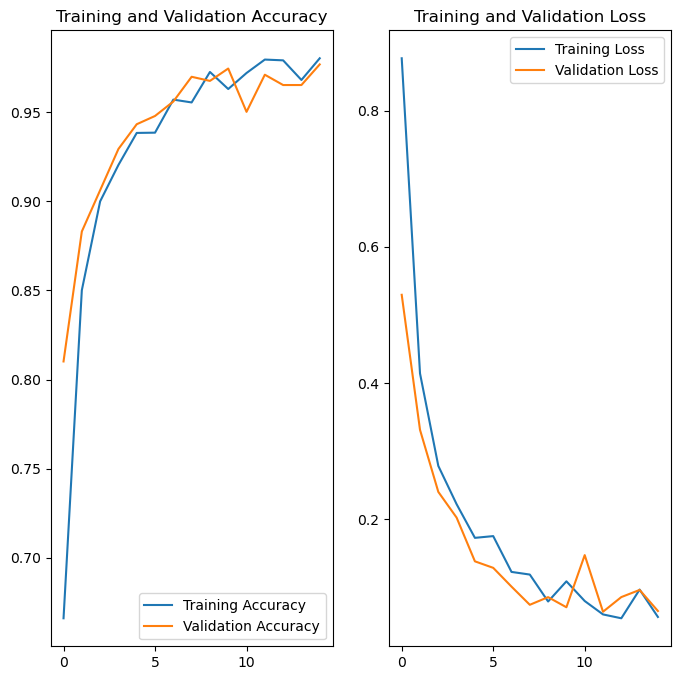

In [49]:
# Plotting graphs
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [50]:
# Predicting from the model
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 24ms/step


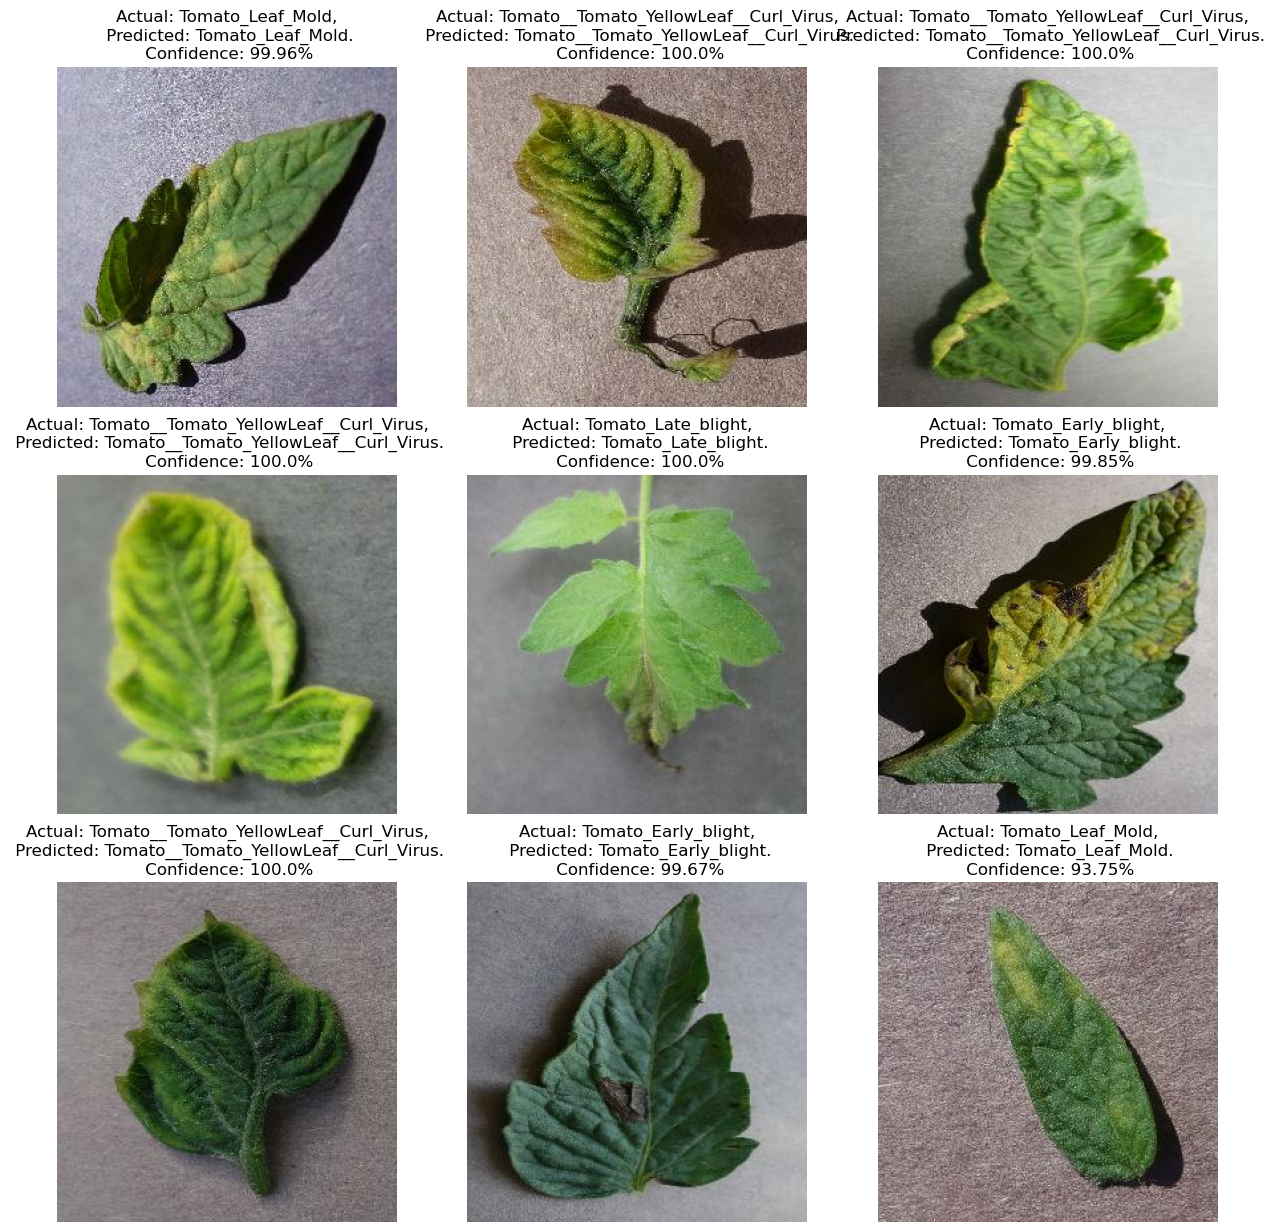

In [51]:
# Plot more predictions with images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [52]:
# Save the model
model.save("tdcm1.h5")
